# 6: Predictive Modeling

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Feature Engineering

In [2]:
# Load dataset
df = pd.read_csv('test_labeled_1.csv')
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date', 'from'])

# Combine text fields
Text = df['text'].fillna(df['Subject'].fillna('') + " " + df['body'].fillna('')).fillna('')
df['combined_text'] = Text

# Map sentiment to numeric score
score_map = {'Positive': 1, 'Negative': -1, 'Neutral': 0}
df['msg_score'] = df['sentiment'].map(score_map).fillna(0).astype(int)


# Feature engineering

df['YearMonth'] = df['date'].dt.to_period('M')
df['is_weekend'] = df['date'].dt.dayofweek >= 5
df['len_chars'] = df['combined_text'].str.len()
df['len_words'] = df['combined_text'].str.split().apply(len)

# Aggregate per sender per month
agg = {
    'msg_score': ['sum', 'count'],
    'len_chars': ['mean'],
    'len_words': ['mean', 'max'],
    'is_weekend': ['mean'],
    'date': [lambda s: s.dt.date.nunique()]
}

monthly = df.groupby(['from', 'YearMonth']).agg(agg)
monthly.columns = [
    'score_sum', 'msg_count',
    'avg_len_chars',
    'avg_len_words', 'max_len_words',
    'weekend_share',
    'active_days'
]
monthly = monthly.reset_index()

# Sentiment counts
sent_ct = df.pivot_table(
    index=['from','YearMonth'], 
    columns='sentiment', 
    values='combined_text', 
    aggfunc='count', 
    fill_value=0
)
for c in ['Positive','Negative','Neutral']:
    if c not in sent_ct.columns:
        sent_ct[c] = 0
sent_ct = sent_ct.reset_index().rename(columns={
    'Positive':'pos_count','Negative':'neg_count','Neutral':'neu_count'
})

feat = monthly.merge(sent_ct, on=['from','YearMonth'], how='left')
feat['pos_ratio'] = (feat['pos_count'] / feat['msg_count']).replace([np.inf, np.nan], 0.0)
feat['neg_ratio'] = (feat['neg_count'] / feat['msg_count']).replace([np.inf, np.nan], 0.0)
feat['target_score'] = feat['score_sum']

# Lag and rolling features
feat = feat.sort_values(['from','YearMonth'])
for lag in range(1, 4):
    feat[f'lag{lag}_score'] = feat.groupby('from')['target_score'].shift(lag).fillna(0)
feat['rolling3_score'] = feat.groupby('from')['target_score'].transform(lambda s: s.shift(1).rolling(3).mean()).fillna(0)

# Interaction terms
feat['lag1_pos_inter'] = feat['lag1_score'] * feat['pos_ratio']
feat['lag1_neg_inter'] = feat['lag1_score'] * feat['neg_ratio']

# Frequent sender flag
sender_msg_counts = feat.groupby('from')['msg_count'].sum()
threshold = sender_msg_counts.median()
feat['is_frequent_sender'] = feat['from'].map(lambda x: 1 if sender_msg_counts[x] > threshold else 0)


## Model Development

In [3]:
#  Prepare features and target

feature_cols = [
    'avg_len_chars', 'avg_len_words', 'max_len_words',
    'weekend_share', 'active_days',
    'pos_ratio', 'neg_ratio',
    'lag1_score', 'lag2_score', 'lag3_score', 'rolling3_score',
    'lag1_pos_inter', 'lag1_neg_inter',
    'is_frequent_sender'
]

X = feat[feature_cols].fillna(0)
y = feat['target_score'].values

print(f"Target range: {y.min():.2f} to {y.max():.2f}")

# train-test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Feature selection with LassoCV

lasso_fs = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LassoCV(cv=5, random_state=42, max_iter=10000))
])
lasso_fs.fit(X_train, y_train)
coef = lasso_fs.named_steps['model'].coef_
selected_features = [f for f, c in zip(feature_cols, coef) if abs(c) > 1e-6]
print("\nSelected features after LassoCV:", selected_features)

# Keep only selected features and replace Inf/NaN
X_train = X_train[selected_features].replace([np.inf, -np.inf], 0).fillna(0)
X_test  = X_test[selected_features].replace([np.inf, -np.inf], 0).fillna(0)


# Linear Regression with Polynomial Interactions

preprocess = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False))
        ]), selected_features)
    ]
)

linear_model = LinearRegression()
model = Pipeline([('prep', preprocess), ('model', linear_model)])

# Train model
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)


# Evaluate

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)


print("\nLinear Regression Performance:")
print(f"  R^2  : {r2:.3f}")
print(f"  MAE  : {mae:.3f}")



Target range: -3.00 to 14.00

Selected features after LassoCV: ['max_len_words', 'active_days', 'pos_ratio', 'neg_ratio', 'lag1_neg_inter']

Linear Regression Performance:
  R^2  : 0.921
  MAE  : 0.525


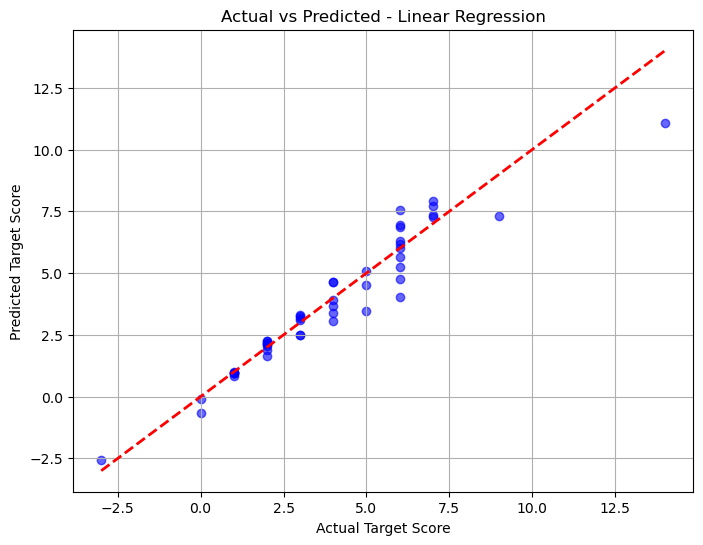

<Figure size 640x480 with 0 Axes>

In [4]:
# Actual vs Prediction plot
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Target Score")
plt.ylabel("Predicted Target Score")
plt.title("Actual vs Predicted - Linear Regression")
plt.grid(True)
plt.show()
plt.savefig("Actual vs Predicted.png")

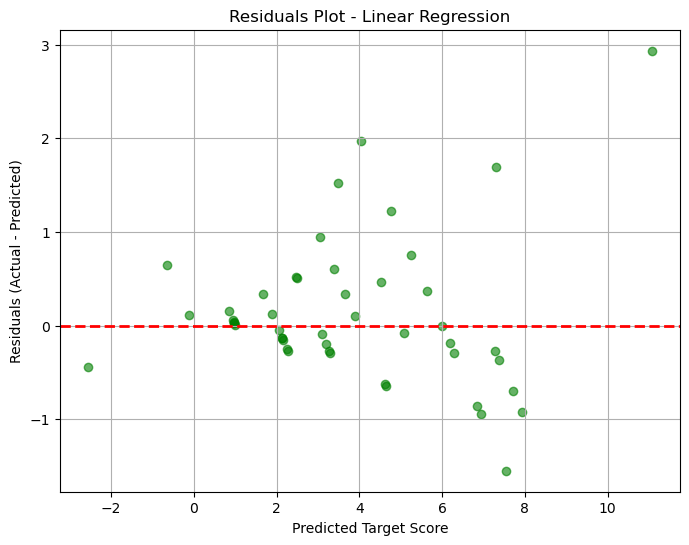

<Figure size 640x480 with 0 Axes>

In [5]:
# Residual plot
residuals = y_test - y_pred

plt.figure(figsize=(8,6))
plt.scatter(y_pred, residuals, alpha=0.6, color='green')
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel("Predicted Target Score")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals Plot - Linear Regression")
plt.grid(True)
plt.show()
plt.savefig("Residual plot.png")

### Feature Coefficients


Top 15 coefficients (by absolute value):
                         Feature  Coefficient
1                    active_days     2.318322
2                      pos_ratio     2.050234
9          active_days pos_ratio     1.230477
3                      neg_ratio    -1.036169
10         active_days neg_ratio    -0.728769
5      max_len_words active_days     0.225608
0                  max_len_words     0.159957
8   max_len_words lag1_neg_inter    -0.049260
14      neg_ratio lag1_neg_inter    -0.034732
7        max_len_words neg_ratio     0.031960
6        max_len_words pos_ratio     0.028752
4                 lag1_neg_inter     0.023055
11    active_days lag1_neg_inter     0.020044
13      pos_ratio lag1_neg_inter     0.008974
12           pos_ratio neg_ratio     0.008137


<Figure size 1000x600 with 0 Axes>

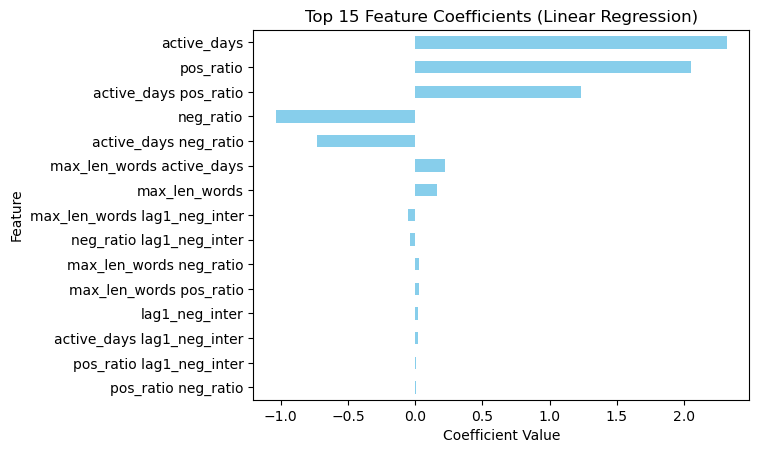

<Figure size 640x480 with 0 Axes>

In [6]:
#  Extract and display feature coefficients

# Get feature names after polynomial expansion
feature_names = preprocess.named_transformers_['num'].named_steps['poly'].get_feature_names_out(selected_features)

# Get coefficients from linear regression
coefs = model.named_steps['model'].coef_

# Combine into DataFrame
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefs
})

# Sort by absolute coefficient strength
coef_df = coef_df.sort_values(by="Coefficient", key=np.abs, ascending=False)

print("\nTop 15 coefficients (by absolute value):")
print(coef_df.head(15))


# Plot top 15 coefficients

plt.figure(figsize=(10,6))
coef_df.head(15).plot(kind='barh', x='Feature', y='Coefficient', legend=False, color='skyblue')
plt.title("Top 15 Feature Coefficients (Linear Regression)")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.show()
plt.savefig("Feature Coeffiecients.png")


# Summary





## Features Used: 
### max_len_words 		 - The maximum number of words in a single message by a user
### active_days	 - The number of days a user has been active (sending at least one message).
### pos_ratio	 - Ratio (proportion) of messages with positive sentiment relative to total messages.
### neg_ratio	 - Ratio (proportion) of messages with negative sentiment relative to total messages.
### lag1_neg_inter	 - Interaction between previous time-step behaviour and negative sentiment (a lagged                                              negative ratio feature).  
### active_days * pos_ratio	 - Users who are both active and positive show stronger performance.
### active_days * neg_ratio	 - Users who are active but negative reduce performance.
### max_len_words * active_days	 - Users who are active and write longer messages contribute positively.
### max_len_words * neg_ratio - Long messages that are negative slightly reduce outcomes.
### max_len_words * pos_ratio - Long messages with positive sentiment slightly increase outcomes.
### max_len_words * lag1_neg_inter - max_len_words * lag1_neg_inter
### active_days * lag1_neg_inter - Active users with past negative behaviour.
### pos_ratio * neg_ratio - Users expressing both positive and negative sentiment.
### pos_ratio * lag1_neg_inter - Positive communication interacting with past negativity.
### neg_ratio * lag1_neg_inter - Current negativity combined with a history of negativity.

### Target Variable: Sentiment_Score (Target range: -3.00 to 14.00)

## Training Method: 80/20 Train–Test split

## Evaluation Metrics:
### MAE  : 0.525 -  On average, predictions differ from actual sentiment scores by ~0.53 units. Target score ranges from -3 to 14, this error represents only ~3.1% of the possible range.
### R² 0.921 - The model explains 92.1% of the variance in sentiment scores.


